In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import ndimage as ndi
import os
import glob
import time
import pickle
import matplotlib.pyplot as plt
import re
import random

In [6]:
import skimage.io as io
from skimage import feature
from skimage.color import rgb2gray
from skimage.exposure import equalize_hist

In [7]:
import os
from tqdm import tqdm # smart progress bar


# ================  GRAPHICS
from PIL import Image

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc_params
 
# get our styles
mpl_default = rc_params()
 
import seaborn as sns
sns.set(rc=mpl_default)
 
%matplotlib inline
plt.rcParams = mpl_default

# ================  NUMBERS AND MATHS AND THINGS
import pandas as pd
import numpy as np

# BEES colormap! Black -> Yellow
CMAP = [(0,0,0),
        (22,0,0),
        (43,0,0),
        (77,14,0),
        (149,68,0),
        (220,123,0),
        (255,165,0),
        (255,192,0),
        (255,220,0),
        (255,235,0),
        (255,245,0),
        (255,255,0)]


bees_cm = mpl.colors.ListedColormap(np.array(CMAP)/255.)

In [8]:
bees_cm


In [9]:
# load the labels using pandas
labels = pd.read_csv("/home/mikez/ds/metis/mcnulty_project/bees/beelabels.csv",
                     index_col=0)

submission_format = pd.read_csv("/home/mikez/ds/metis/mcnulty_project/bees/SubmissionFormat.csv",
                                index_col=0)

print "Number of training examples is: ", labels.shape[0]
print "Predictions should be type:", labels.dtypes[0]
labels.head()

Number of training examples is:  3969
Predictions should be type: float64


,genus
id,
520,1
3800,1
3289,1
2695,1
4922,1


In [10]:
def get_image(row_or_str, root="/home/mikez/ds/metis/mcnulty_project/bees/"):
    # if we have an instance from the data frame, pull out the id
    # otherwise, it is a string for the image id
    if isinstance(row_or_str, pd.core.series.Series):
        row_id = row_or_str.name
    else:
        row_id = row_or_str
    
    filename = "{}.jpg".format(row_id)
    
    # test both of these so we don't have to specify. Image should be
    # in one of these two. If not, we let Image.open raise an exception.
    train_path = os.path.join(root, "train", filename)
    test_path = os.path.join(root, "test", filename)
    
    file_path = train_path if os.path.exists(train_path) else test_path
    
    return np.array(Image.open(file_path), dtype=np.int32)
        

# make sure it works for strings and series
assert (get_image(labels.iloc[0]) == get_image("520")).all()

# confirm images are the same shape
print "Size of image 520:  ", get_image("520").shape
print "Size of image 1001: ", get_image("1001").shape

Size of image 520:   (200, 200, 3)
Size of image 1001:  (200, 200, 3)


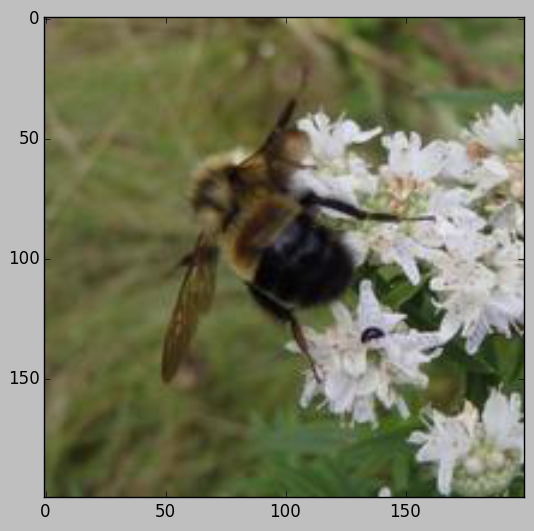

In [11]:
# imshow expects floats between 0-1, but we have
# integers 0-255 from PIL so we need to rescale to view the image
plt.imshow((get_image("520") / 255.))

array([ 201.,  194.,  127., ...,  179.,  177.,  171.])

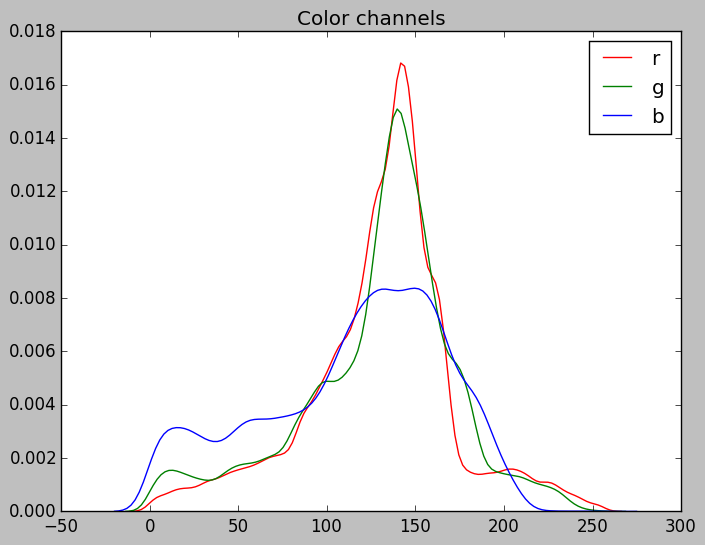

In [12]:
def extract_rgb_info(rgb, ax=None):
    """Extract color statistics as features:
        - pixel values (flattened)
        - X, Y sums per channel
        - percentiles per channel
        - percentile diffs per channel

        Plots if ax is passed
    """
    # toss alpha if it exists
    if rgb.shape[2] == 4:
        rgb = rgb[:, :, :3]

    # start with raw pixel values as features
    features = [rgb.flatten()]

    # add some basic statistics on the color channels (R, G, B)
    for channel in range(3):
        this_channel = rgb[:, :, channel].astype(np.float)
        sums = np.hstack([this_channel.sum(),
                          this_channel.sum(axis=0),
                          this_channel.sum(axis=1)])

        # percentiles
        ps = [1, 3, 5, 10, 50, 90, 95, 97, 99]
        percentiles = np.array(np.percentile(this_channel, ps))
        diff = percentiles[-4:] - percentiles[:4]
        
        # plot if we have been passed an axis
        if ax is not None:
            channel_name = ['r', 'g', 'b'][channel]       
            sns.kdeplot(this_channel.flatten(),
                        ax=ax,
                        label=channel_name,
                        color=channel_name)
            ax.set_title("Color channels")

        
        # store the features for this channel
        
        features += [sums, percentiles, diff]
        
    # return all the color features as a flat array
    return np.hstack(features).flatten()

extract_rgb_info(get_image("1974"), ax=plt.gca())

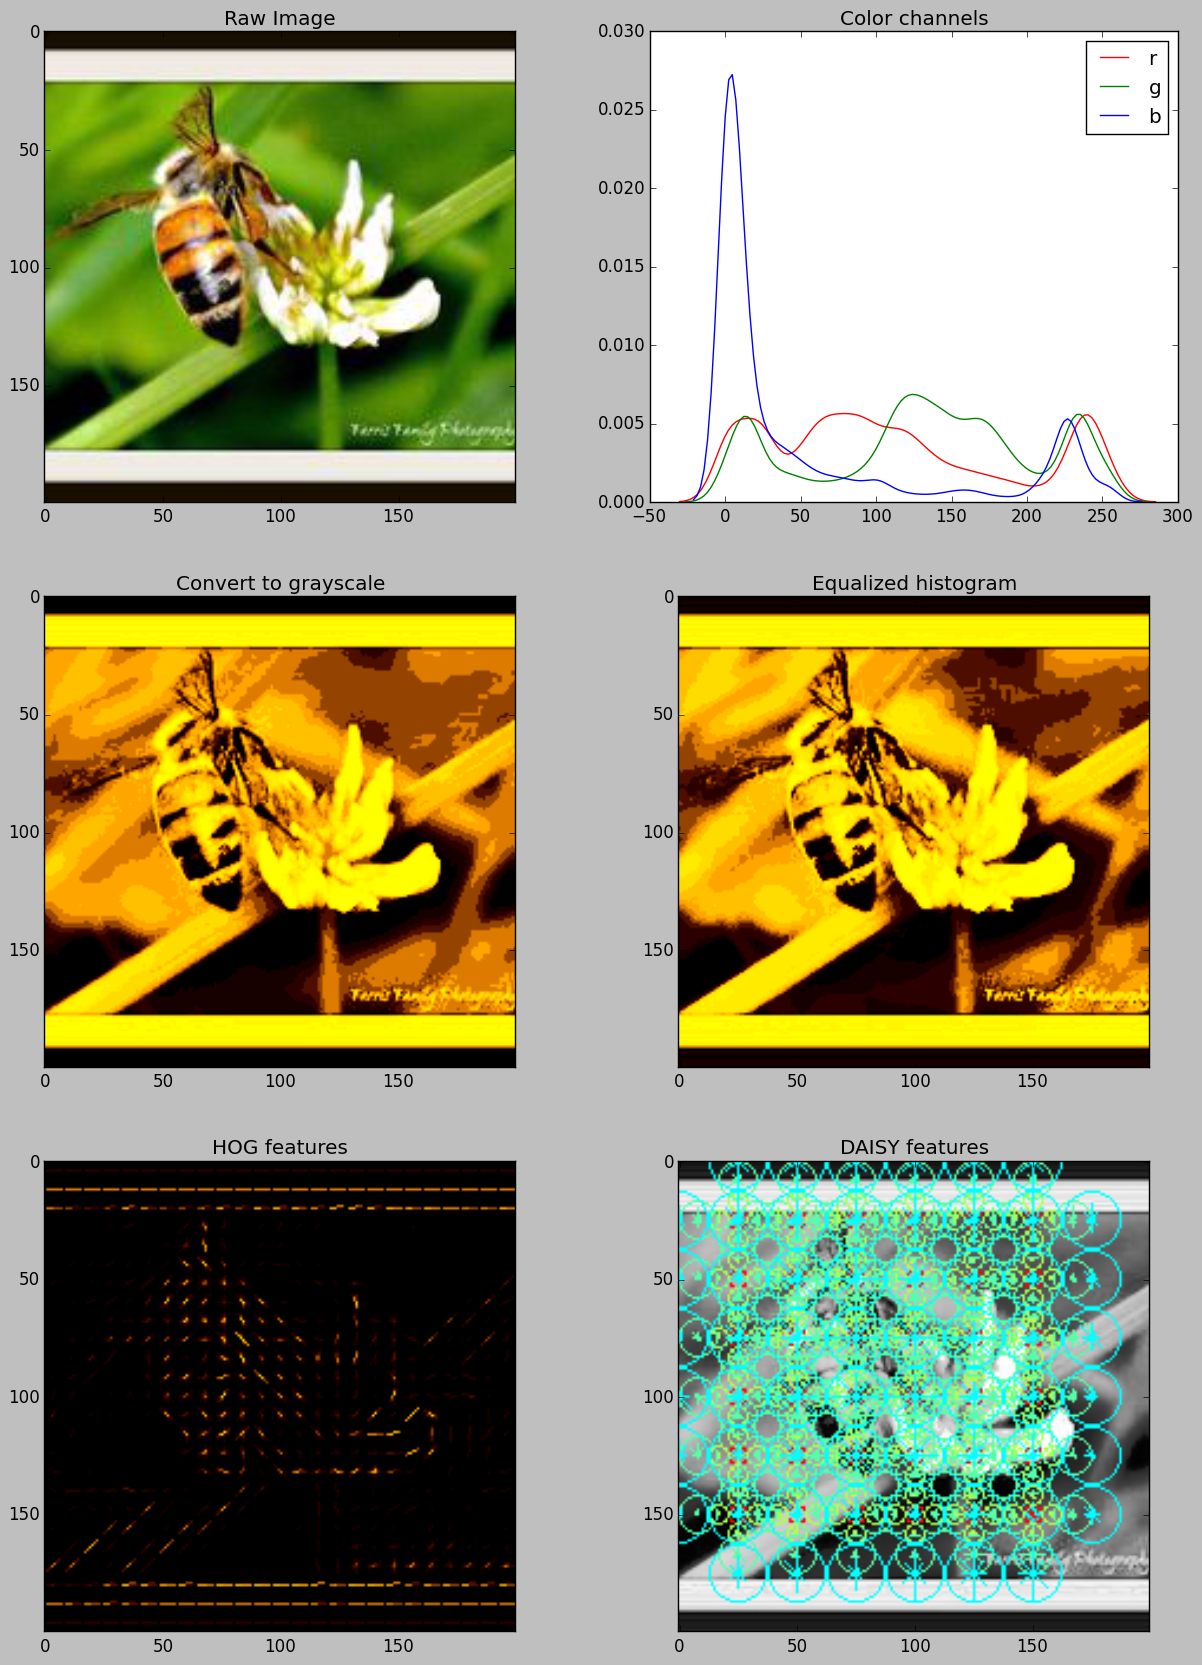

In [13]:
from skimage.feature import daisy
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.exposure import equalize_hist

def preprocess(img, demo=False):
    """ Turn raw pixel values into features.
    """
    
    def _demo_plot(img, stage="", is_ints=False, axes_idx=0):
        """ Utility to visualize the features we're building
        """
        if demo:
            axes[axes_idx].imshow(img / 255. if is_ints else img,
                                  cmap=bees_cm)
            axes[axes_idx].set_title(stage)
        return axes_idx + 1

    if demo:
        fig, axes = plt.subplots(3, 2, figsize=(15, 20))
        axes = axes.flatten()
    
    # track which subplot we're plotting to
    axes_idx = 0
    axes_idx = _demo_plot(img, stage="Raw Image", is_ints=True, axes_idx=axes_idx)
        
    # FEATURE 1: Raw image and color data    
    if demo:
        color_info = extract_rgb_info(img, ax=axes[axes_idx])
        axes_idx += 1
    else:
        color_info = extract_rgb_info(img)
    
    # remove color information (hog and daisy only work on grayscale)
    gray = rgb2gray(img)
    axes_idx = _demo_plot(gray, stage="Convert to grayscale", axes_idx=axes_idx)
    
    # equalize the image
    gray = equalize_hist(gray)
    axes_idx = _demo_plot(gray, stage="Equalized histogram", axes_idx=axes_idx)
    
    # FEATURE 2: histogram of oriented gradients features
    hog_features = hog(gray,
                       orientations=12,
                       pixels_per_cell=(8, 8),
                       cells_per_block=(1, 1),
                       visualise=demo)
    
    # if demo, we actually got a tuple back; unpack it and plot
    if demo:
        hog_features, hog_image = hog_features
        axes_idx = _demo_plot(hog_image, stage="HOG features", axes_idx=axes_idx)
        
    # FEATURE 3: DAISY features - sparser for demo so can be visualized
    params = {'step': 25, 'radius': 25, 'rings': 3} if demo \
             else {'step': 10, 'radius': 15, 'rings': 4}
    daisy_features = daisy(gray,
                           histograms=4,
                           orientations=8,
                           normalization='l1',
                           visualize=demo,
                           **params)
        
    if demo:
        daisy_features, daisy_image = daisy_features
        axes_idx = _demo_plot(daisy_image, stage="DAISY features", axes_idx=axes_idx)
    
    # return a flat array of the raw, hog and daisy features
    return np.hstack([color_info, hog_features, daisy_features.flatten()])


preprocess_result = preprocess(get_image("4213"), demo=True)

In [12]:
def create_feature_matrix(label_dataframe):
    n_imgs = label_dataframe.shape[0]
    
    # initialized after first call to 
    feature_matrix = None
    
    for i, img_id in tqdm(enumerate(label_dataframe.index)):
        features = preprocess(get_image(img_id))
        
        # initialize the results matrix if we need to
        # this is so n_features can change as preprocess changes
        if feature_matrix is None:
            n_features = features.shape[0]
            feature_matrix = np.zeros((n_imgs, n_features), dtype=np.float32)
            
        if not features.shape[0] == n_features:
            print "Error on image {}".format(img_id)
            features = features[:n_features]
        
        feature_matrix[i, :] = features
        
    return feature_matrix

# turn those images into features!
bees_features = create_feature_matrix(labels)

# save in case we need to load later; creating this takes
# a little while and it ends up being ~3GBs
np.save("bees_features.npy", bees_features)

0it [00:00, ?it/s]

NameError: global name 'preprocess' is not defined

In [15]:
bees_features = np.load("bees_features.npy")

/home/mikez/anaconda/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warnings.warn("Float image out of standard range; displaying "


/home/mikez/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


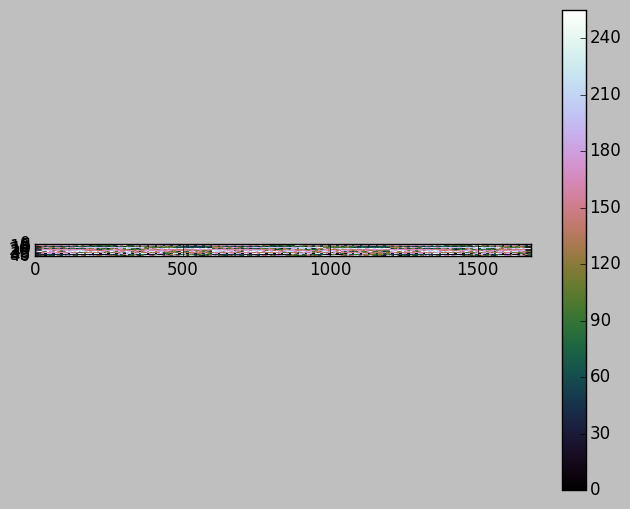

In [16]:
io.imshow(bees_features[:39.69,:1680.46])

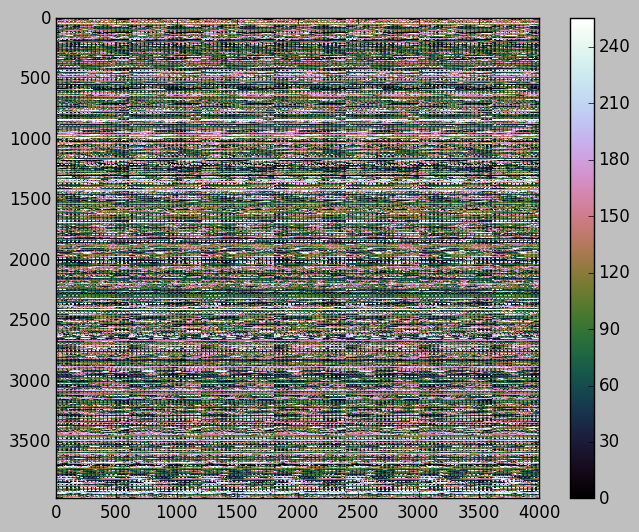

In [17]:
io.imshow(bees_features[:4000,:4000])

In [36]:
from sklearn.preprocessing import StandardScaler

In [37]:
ss = StandardScaler()

In [38]:
bees_stand = ss.fit_transform(bees_features[:39.69,:1680.46])
#(39.69, 1680.46)

In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1000)
bees_pca = pca.fit_transform(bees_stand)

/home/mikez/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [34]:
bees_stand

array([[ 0.20222586, -0.22737645,  0.33665326, ...,  1.27908361,
         0.91094851,  1.12167215],
       [-1.33266902, -1.35011506, -0.97620022, ...,  0.95536333,
         0.17059305, -0.59844792],
       [ 0.71385747,  1.08248532,  0.83910334, ...,  0.36527461,
        -0.25010547, -0.7375626 ],
       ..., 
       [-0.60648215, -0.4893488 ,  0.10974031, ...,  0.06480099,
         0.2896167 ,  0.37761164],
       [ 0.26824284,  0.80180067, -0.16579683, ..., -0.64038795,
        -0.52698463, -0.76934892],
       [-0.73851615, -0.91973197, -0.95999217, ...,  0.43808541,
         0.04573729, -0.33046481]], dtype=float32)